# Energy Explorary Analysis

In [70]:
import numpy as np
import pandas as pd
import os
        
import requests
import json

from scipy.stats import pearsonr,spearmanr, boxcox
from scipy import stats

from statsmodels.graphics.gofplots import qqplot

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go

from IPython.display import display, Image

# pio.renderers.default = 'browser'
pio.renderers.default = 'notebook'

import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc

from jupyter_dash import JupyterDash

import warnings
warnings.filterwarnings('ignore')

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

rand_state=1000

In [2]:
# numeric columns
def numeric_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64[ns]']
    df_numeric = df.select_dtypes(include=numerics)
    return df_numeric.columns.tolist()

# object columns
def object_columns(df):
    objects = ['object']
    df_object = df.select_dtypes(include=objects)
    return df_object.columns.tolist()

# change column data type to categorical
def cat_features(df, ls):
    for l in ls:
        df[l]=df[l].astype(str)
    return df

# change column data type to float
def num_features(df, ls):
    for l in ls:
        df[l]=df[l].astype(float)
    return df

def missing_percentage(df, title):
    nadf=(round(df.isna().sum().sort_values(ascending=True)/len(df),4)).reset_index()
    nadf.columns=['Variable','Missing_percentage']
    nadf=nadf[nadf['Missing_percentage']>0].sort_values(by='Missing_percentage', ascending=False)

    if len(nadf)>0 :        
        fig, ax = plt.subplots(figsize=(8,3))
        sns.barplot(x='Missing_percentage',
               y='Variable',
               data=nadf.head(50),
               palette='Spectral').set(title=title)
    
    return nadf

In [3]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

def find_outliers_plots(df, feature):
    outliers=find_outliers_IQR(df)[feature]
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min()))
    
    fig = px.histogram(df, x=feature,
                   title='Histogram of '+ feature ,
                   labels={feature:feature}, # can specify one label per df column
                   opacity=0.8,
                   log_y=False, # represent bars with log scale
#                    color_discrete_sequence=['indianred'] # color of histogram bars
                   )
    
    fig = px.histogram(df, x=feature,
                   title='Histogram of '+ feature +'(Log Scaled)',
                   labels={feature:feature}, # can specify one label per df column
                   opacity=0.8,
                   log_y=True, # represent bars with log scale
#                    color_discrete_sequence=['indianred'] # color of histogram bars
                   )
    
    fig = px.box(df, y=feature)      

    fig.show()
    
    return outliers

def cap_outliers(df, feature):
    upper_limit = df[feature].mean() + 3*df[feature].std()
    lower_limit = df[feature].mean() - 3*df[feature].std()
    print('normal range:', lower_limit, upper_limit)
    df[feature] = np.where(df[feature] > upper_limit,
                                 upper_limit,
                                 np.where(
                                     df[feature] < lower_limit,
                                     lower_limit,
                                     df[feature]
                                 )
                          )
    return df[feature]

def impute_outliers_IQR(df, feature, style):
    q1=df[feature].quantile(0.25)
    q3=df[feature].quantile(0.75)
    IQR=q3-q1
    upper = df[feature][~(df[feature]>(q3+1.5*IQR))].max()
    lower = df[feature][~(df[feature]<(q1-1.5*IQR))].min()
    print('normal range: ', lower, upper)
    if style.upper()=='MEAN':
          value=df[feature].mean()
    elif style.upper()=='MEDIAN':
          value=df[feature].median()
    elif style.upper()=='MODE':
          value=df[feature].mode() # most frequently used value
    else:
          value=0
    df[feature] = np.where(df[feature] > upper,
                           value,
                           np.where(
                               df[feature] < lower,
                               value,
                               df[feature]
                           )
                          )
    return df[feature]
          
def impute_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    upper = df[~(df>(q3+1.5*IQR))].max()
    lower = df[~(df<(q1-1.5*IQR))].min()
    df = np.where(df > upper,
       df.median(),
       np.where(
           df < lower,
           df.median(),
           df
           ))
    return df    

def drop_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    outliers_dropped = outliers.dropna().reset_index()
    return outliers_dropped          

## Import Data from CSV Generated in The Last Step

In [25]:
energy=pd.read_csv('energy.csv').drop('Unnamed: 0',axis=1)
df_energy=energy[['Annual Maximum Demand (kW)',
 'Annual Maximum Demand Intensity (kW/ft2)',
 'Avoided Emissions - Offsite Green Power (Metric Tons CO2e)',
 'Avoided Emissions - Offsite Green Power Intensity (Metric Tons CO2e/ft2)',
 'Avoided Emissions - Onsite Green Power (Metric Tons CO2e)',
 'Avoided Emissions - Onsite Green Power Intensity (Metric Tons CO2e/ft2)',
 'Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)',
 'Avoided Emissions - Onsite and Offsite Green Power Intensity (Metric Tons CO2e)',
 'Community Board',
 'Diesel #2 Use (kBtu)',
 'Diesel #2 Use Intensity (kBtu/ft2)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Direct GHG Emissions Intensity (kgCO2e/ft²)',
 'District Chilled Water Use (kBtu)',
 'District Chilled Water Use Intensity (kBtu/ft2)',
 'District Steam Use (kBtu)',
 'District Steam Use Intensity (kBtu/ft2)',
 'ENERGY STAR Score',
 'Electricity Use - Grid Purchase (kBtu)',
 'Electricity Use - Grid Purchase Intensity (kBtu/ft2)',
 'Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kBtu)',
 'Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems Intensity (kBtu/ft2)',
 'Electricity Use – Generated from Onsite Renewable Systems (kBtu)',
 'Electricity Use – Generated from Onsite Renewable Systems Intensity (kBtu/ft2)',
 'Electricity Use – Generated from Onsite Renewable Systems and Exported (kBtu)',
 'Electricity Use – Generated from Onsite Renewable Systems and Exported Intensity (kBtu/ft2)',
 'Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kBtu)',
 'Electricity Use – Generated from Onsite Renewable Systems and Used Onsite Intensity (kBtu/ft2)',
 'Fuel Oil #1 Use (kBtu)',
 'Fuel Oil #1 Use Intensity (kBtu/ft2)',
 'Fuel Oil #2 Use (kBtu)',
 'Fuel Oil #2 Use Intensity (kBtu/ft2)',
 'Fuel Oil #4 Use (kBtu)',
 'Fuel Oil #4 Use Intensity (kBtu/ft2)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Fuel Oil #5 & 6 Use Intensity (kBtu/ft2)',
 'Fuel Oil Use Total (kBtu)',
 'Fuel Oil Use Total Intensity (kBtu/ft2)',
 'Green Power - Offsite (kBtu)',
 'Green Power - Offsite Intensity (kBtu/ft2)',
 'Green Power - Onsite (kBtu)',
 'Green Power - Onsite Intensity (kBtu/ft2)',
 'Green Power - Onsite and Offsite (KBtu)',
 'Green Power - Onsite and Offsite Intensity (kBtu/ft2)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions Intensity (kgCO2e/ft²)',
 'Indoor Water Use (All Water Sources) (kgal)',
 'Indoor Water Use (All Water Sources) Intensity (kgal/ft2)',
 'Multifamily Housing - Gross Floor Area (ft²)',
 'Multifamily Housing - Number of Bedrooms',
 'Multifamily Housing - Number of Bedrooms Density (Number per 1,000 sq ft)',
 'Multifamily Housing - Number of Laundry Hookups in All Units',
 'Multifamily Housing - Number of Laundry Hookups in Common Area(s)',
 'Multifamily Housing - Number of Residential Living Units in a High-Rise Building (10 or more Stories)',
 'Multifamily Housing - Number of Residential Living Units in a High-Rise Building Density (Number per 1,000 sq ft)',
 'Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building (5-9 Stories)',
 'Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building Density (Number per 1,000 sq ft)',
 'Multifamily Housing - Percent That Can Be Cooled',
 'Multifamily Housing - Percent That Can Be Heated',
 'Multifamily Housing - Total Number of Residential Living Units',
 'Multifamily Housing - Total Number of Residential Living Units Density (Number per 1,000 sq ft)',
 'Municipally Supplied Potable Water - Indoor Use (kgal)',
 'Municipally Supplied Potable Water - Indoor Use Intensity (kgal/ft2)',
 'Municipally Supplied Potable Water - Mixed Indoor/Outdoor Use (kgal)',
 'Municipally Supplied Potable Water - Mixed Indoor/Outdoor Use Intensity (kgal/ft2)',
 'Municipally Supplied Potable Water - Outdoor Use (kgal)',
 'Municipally Supplied Potable Water - Outdoor Use Intensity (kgal/ft2)',
 'Municipally Supplied Potable Water - Total Use (All Meter Types) (kgal)',
 'Municipally Supplied Potable Water - Total Use (All Meter Types) Intensity (kgal/ft2)',
 'National Median Site EUI (kBtu/ft²)',
 'National Median Source EUI (kBtu/ft²)',
 'National Median Total GHG Emissions (Metric Tons CO2e)',
 'National Median Total GHG Emissions Intensity (Metric Tons CO2e/ft2)',
 'Natural Gas Use (kBtu)',
 'Natural Gas Use Intensity (kBtu/ft2)',
 'Net Emissions (Metric Tons CO2e)',
 'Net Emissions Intensity (Metric Tons CO2e/ft2)',
 'Outdoor Water Use (All Water Sources) (kgal)',
 'Outdoor Water Use (All Water Sources) Intensity (kgal/ft2)',
 'Percent of Electricity that is Green Power',
 'Percent of RECs Retained',
 'Percent of Total Electricity Generated from Onsite Renewable Systems',
 'Property GFA - Calculated (Buildings and Parking) (ft²)',
 'Property GFA - Calculated (Buildings) (ft²)',
 'Property GFA - Calculated (Parking) (ft²)',
 'Property GFA - Self-Reported (ft²)',
 'Site EUI (kBtu/ft²)',
 'Site Energy Use (kBtu)',
 'Source EUI (kBtu/ft²)',
 'Source Energy Use (kBtu)',
 'Total GHG Emissions (Metric Tons CO2e)',
 'Total GHG Emissions Intensity (kgCO2e/ft²)',
 'Water Use (All Water Sources) (kgal)',
 'Water Use (All Water Sources) Intensity (kgal/ft2)',
 'Weather Normalized Site EUI (kBtu/ft²)',
 'Weather Normalized Site Electricity (kBtu)',
 'Weather Normalized Site Electricity Intensity (kBtu/ft²)',
 'Weather Normalized Site Energy Use (kBtu)',
 'Weather Normalized Site Natural Gas Intensity (kBtu/ft²)',
 'Weather Normalized Site Natural Gas Use (kBtu)',
 'Weather Normalized Source EUI (kBtu/ft²)',
 'Weather Normalized Source Energy Use (kBtu)',
 'eGRID Output Emissions Rate (kgCO2e/MBtu)']]

In [26]:
l=[
 'Annual Maximum Demand Intensity (kW/ft2)',
 'Avoided Emissions - Offsite Green Power Intensity (Metric Tons CO2e/ft2)',
 'Avoided Emissions - Onsite Green Power Intensity (Metric Tons CO2e/ft2)',
 'Diesel #2 Use Intensity (kBtu/ft2)',
 'Direct GHG Emissions Intensity (kgCO2e/ft²)',
 'District Chilled Water Use Intensity (kBtu/ft2)',
 'District Steam Use Intensity (kBtu/ft2)',
 'Electricity Use - Grid Purchase Intensity (kBtu/ft2)',
 'Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems Intensity (kBtu/ft2)',
 'Electricity Use – Generated from Onsite Renewable Systems Intensity (kBtu/ft2)',
 'Electricity Use – Generated from Onsite Renewable Systems and Exported Intensity (kBtu/ft2)',
 'Electricity Use – Generated from Onsite Renewable Systems and Used Onsite Intensity (kBtu/ft2)',
 'Fuel Oil #1 Use Intensity (kBtu/ft2)',
 'Fuel Oil #2 Use Intensity (kBtu/ft2)',
 'Fuel Oil #4 Use Intensity (kBtu/ft2)',
 'Fuel Oil #5 & 6 Use Intensity (kBtu/ft2)',
 'Fuel Oil Use Total Intensity (kBtu/ft2)',
 'Green Power - Offsite Intensity (kBtu/ft2)',
 'Green Power - Onsite Intensity (kBtu/ft2)',
 'Green Power - Onsite and Offsite Intensity (kBtu/ft2)',
 'Indirect GHG Emissions Intensity (kgCO2e/ft²)',
 'Indoor Water Use (All Water Sources) Intensity (kgal/ft2)',
 'Multifamily Housing - Number of Bedrooms Density (Number per 1,000 sq ft)',
 'Multifamily Housing - Number of Residential Living Units in a High-Rise Building Density (Number per 1,000 sq ft)',
 'Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building Density (Number per 1,000 sq ft)',
 'Multifamily Housing - Total Number of Residential Living Units Density (Number per 1,000 sq ft)',
 'Municipally Supplied Potable Water - Indoor Use Intensity (kgal/ft2)',
 'Municipally Supplied Potable Water - Mixed Indoor/Outdoor Use Intensity (kgal/ft2)',
 'Municipally Supplied Potable Water - Outdoor Use Intensity (kgal/ft2)',
 'Municipally Supplied Potable Water - Total Use (All Meter Types) Intensity (kgal/ft2)',
 'National Median Site EUI (kBtu/ft²)',
 'National Median Source EUI (kBtu/ft²)',
 'National Median Total GHG Emissions Intensity (Metric Tons CO2e/ft2)',
 'Natural Gas Use Intensity (kBtu/ft2)',
 'Net Emissions Intensity (Metric Tons CO2e/ft2)',
 'Outdoor Water Use (All Water Sources) Intensity (kgal/ft2)',
 'Site EUI (kBtu/ft²)',
 'Source EUI (kBtu/ft²)',
 'Total GHG Emissions Intensity (kgCO2e/ft²)',
 'Water Use (All Water Sources) Intensity (kgal/ft2)',
 'Weather Normalized Site EUI (kBtu/ft²)',
 'Weather Normalized Site Electricity Intensity (kBtu/ft²)',
 'Weather Normalized Site Natural Gas Intensity (kBtu/ft²)',
 'Weather Normalized Source EUI (kBtu/ft²)',
 'eGRID Output Emissions Rate (kgCO2e/MBtu)']

# if there are over 1000 records for a column(feature), its outliers will be imputed with median value
# all imputed features are intensity features.
df1=df_energy[l].count().to_frame()
l1=df1[df1>1000].dropna(how='any').index.to_list()

df_energy[l1]=impute_outliers_IQR(df_energy[l1])
df=df_energy.sample(frac=0.1, random_state=rand_state)

## Checking Outliers

ref: 
- https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
- https://plotly.com/python/v3/normality-test/
- https://stackoverflow.com/questions/63592900/plotly-dash-how-to-design-the-layout-using-dash-bootstrap-components

# Dash Board

In [27]:
# columns to test outliers
num_columns=numeric_columns(df_energy)
num_columns.sort()

df_outliers=find_outliers_IQR(df_energy)

Dash app running on http://127.0.0.1:8050/


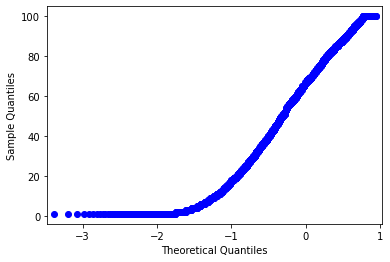

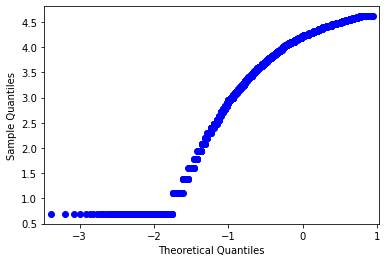

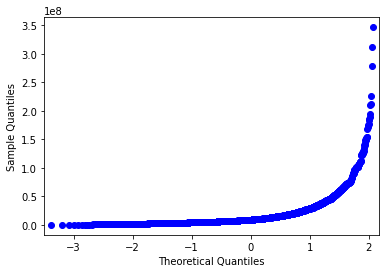

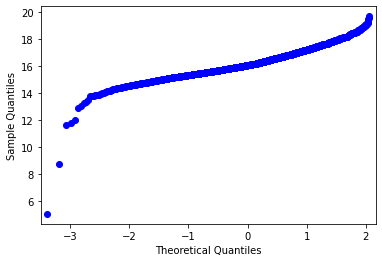

In [64]:
external_stylesheets = [dbc.themes.BOOTSTRAP]

# external_stylesheets = ['learn.css']
# app=dash.Dash(__name__, 
#                 external_stylesheets=external_stylesheets)
app=JupyterDash(__name__, 
                external_stylesheets=external_stylesheets)
app.title="Energy Data - Feature Outliers"
PAGE_SIZE = 10

def drawFigure(id):
    return html.Div([
        dbc.Card(
            dbc.CardBody([
                dcc.Graph(id=id)
            ])
        ), 
    ])

# Text field
def drawText(id):    
    return html.Div([
        dbc.Card(
            [
                dbc.CardBody(
                    [
                        html.Div([                            
                                    html.H6("",id=id)
                        ], style={'textAlign': 'left', 'color':'white'})
                    ]
                )
            ],
            style={"width": "90%","background":"orange"},
        )                
    ])
                           

# Build App

app.layout = html.Div([
    dbc.Card(
        dbc.CardBody([
            dbc.Row([
                dbc.Col([html.Div([
                    dcc.Dropdown(
                        id='columns',
                        options=[{'label': i, 'value': i} for i in num_columns],
                        value='ENERGY STAR Score'
                        )
                    ],
                    style={'width': '85%', 'display': 'inline-block'}),
                ], width=6),
                
                
            ], align='left'), 
            
            
            html.Br(),
            dbc.Row([                
                dbc.Col([
                    dbc.Row([
                        dbc.Col([
                            drawText(id='card1')
                        ], width=10)
                    ], align='left'), 

                    dbc.Row([
                        dbc.Col([
                            drawText(id='card2')
                        ], width=10)
                    ], align='left'), 

                    dbc.Row([
                        dbc.Col([
                            drawText(id='card3')
                        ], width=10)
                    ], align='left'), 

                    dbc.Row([
                        dbc.Col([
                            drawText(id='card4')
                        ], width=10)
                    ], align='left')  
                    ]
                ),
                
                dbc.Col([
                    dbc.Row([
                        dbc.Col([
                            drawText(id='skewness')
                        ], width=15)
                    ], align='left'), 

                    dbc.Row([
                        dbc.Col([
                            drawText(id='Kurtosis')
                        ], width=15)
                    ], align='left'),
                    
                    dbc.Row([
                        dbc.Col([
                            drawText(id='skewness_log')
                        ], width=15)
                    ], align='left'), 

                    dbc.Row([
                        dbc.Col([
                            drawText(id='Kurtosis_log')
                        ], width=15)
                    ], align='center')                    
                    ], align='center'
                )
            ], align='left'), 
        
            dbc.Row([
                dbc.Col([
                    drawFigure(id='histogram') 
                ], width=4),
                dbc.Col([
                    drawFigure(id='qq_plot')
                ], width=4),
                dbc.Col([
                    drawFigure(id='boxplot')
                ], width=4)
            ], align='center'), 
            
        
            dbc.Row([
                dbc.Col([
                    drawFigure(id='histogram_log') 
                ], width=4),
                dbc.Col([
                    drawFigure(id='qq_plot_log')
                ], width=4),
                dbc.Col([
                    drawFigure(id='boxplot_log')
                ], width=4)
            ], align='center'), 
            
            html.Br(),
            dbc.Row([
                dbc.Col([html.Div([
                    dbc.Card(
                        [
                            dbc.CardBody(
                                [
                                    html.Div([                            
                                                html.H6("Outlier Table")
                                    ], style={'textAlign': 'left', 'color':'white'})
                                ]
                            )
                        ],
                        style={"width": "90%","background":"orange"},
                    )                
                ])
                    ]
                )
                
            ], align='left'), 
            
            dbc.Row([
                dash.dash_table.DataTable(
                    id='table-paging-and-sorting',
#                     columns=[
#                         {'name': i, 'id': i, 'deletable': True} for i in sorted(df.columns)
#                     ],
                    page_current=0,
                    page_size=PAGE_SIZE,
                    page_action='custom',

                    sort_action='custom',
                    sort_mode='single',
                    sort_by=[],
                    style_table={'minWidth': '100%'},
                    style_cell={
                        # all three widths are needed
                        'minWidth': '180px', 'width': '180px', 'maxWidth': '180px',
                        'overflow': 'hidden',
                        'textOverflow': 'ellipsis',
                    },
                    style_data_conditional=[
                        {
                            'if': {'row_index': 'odd'},
                            'backgroundColor': 'rgb(220, 220, 220)',
                        }
                    ],
                    style_header={
                        'backgroundColor': '#7FDBFF',
                        'color': 'white',
                        'whiteSpace': 'normal',
                        'height': 'auto',
                    },
#                     style_data={
#                         'backgroundColor': 'rgb(220, 220, 220)',
#                         'color': 'white'
#                     },
                )
            ], align='center'), 
            
            
        ]), color = 'orange'
    )
])


@app.callback(
    dash.dependencies.Output('histogram', 'figure'),
    dash.dependencies.Output('qq_plot', 'figure'),
    dash.dependencies.Output('boxplot', 'figure'),
    dash.dependencies.Output('histogram_log', 'figure'),
    dash.dependencies.Output('qq_plot_log', 'figure'),
    dash.dependencies.Output('boxplot_log', 'figure'), 
    [dash.dependencies.Input('columns', 'value')])
    
def update_figure(xaxis_column_name):
    fig1 = px.histogram(x=df[xaxis_column_name],
                   title='Histogram of '+ xaxis_column_name ,
                   labels={xaxis_column_name:xaxis_column_name}, # can specify one label per df column
                   opacity=0.8
                   )
    
    fig2 = go.Figure()
    qqplot_data = qqplot(df[xaxis_column_name], line='s').gca().lines
    
    fig2.add_trace({
        'type': 'scatter',
        'x': qqplot_data[0].get_xdata(),
        'y': qqplot_data[0].get_ydata(),
        'mode': 'markers',
        'marker': {
            'color': '#19d3f3'
        }
    })

    fig2.add_trace({
        'type': 'scatter',
        'x': qqplot_data[1].get_xdata(),
        'y': qqplot_data[1].get_ydata(),
        'mode': 'lines',
        'line': {
            'color': '#636efa'
        }

    })

    fig2['layout'].update({
        'title': 'Quantile-Quantile Plot of '+ xaxis_column_name ,
        'xaxis': {
            'title': 'Theoritical Quantities',
            'zeroline': False
        },
        'yaxis': {
            'title': 'Sample Quantities'
        },
        'showlegend': False
    })
    
    fig3= px.violin(y=df[xaxis_column_name])  
    fig3['layout'].update({
        'title': 'BoxPlot (log scaled) of '+ xaxis_column_name 
    })
    
    fig4 = px.histogram(x=np.log1p(df[xaxis_column_name]),
                   title='Histogram of '+ xaxis_column_name +' (log scaled)',
                   labels={xaxis_column_name:xaxis_column_name}, # can specify one label per df column
                   opacity=0.8
                   )
                        
    fig5 = go.Figure()
    
    qqplot_data = qqplot(np.log1p(df[xaxis_column_name]), line='s').gca().lines
    
    fig5.add_trace({
        'type': 'scatter',
        'x': qqplot_data[0].get_xdata(),
        'y': qqplot_data[0].get_ydata(),
        'mode': 'markers',
        'marker': {
            'color': '#19d3f3'
        }
    })

    fig5.add_trace({
        'type': 'scatter',
        'x': qqplot_data[1].get_xdata(),
        'y': qqplot_data[1].get_ydata(),
        'mode': 'lines',
        'line': {
            'color': '#636efa'
        }

    })

    fig5['layout'].update({
        'title': 'Quantile-Quantile Plot of '+ xaxis_column_name +' (log scaled)',
        'xaxis': {
            'title': 'Theoritical Quantities',
            'zeroline': False
        },
        'yaxis': {
            'title': 'Sample Quantities'
        },
        'showlegend': False
    })
    
    fig6= px.violin(y=np.log1p(df[xaxis_column_name]))
    fig6['layout'].update({
        'title': 'BoxPlot (log scaled) of '+ xaxis_column_name +' (log scaled)'
    })

    return [fig1, fig2, fig3, fig4, fig5, fig6]

@app.callback(
    dash.dependencies.Output('card1', 'children'),  
    dash.dependencies.Output('card2', 'children'),  
    dash.dependencies.Output('card3', 'children'), 
    dash.dependencies.Output('card4', 'children'),
    [dash.dependencies.Input('columns', 'value')])
    
    
def update_cards(column_name): 
    
    outliers=df_outliers[column_name]
    
    num_nan=len(df_energy[df_energy[column_name].isna()])
    num_outliers=outliers.count()
    max_outliers=outliers.max()
    min_outliers=outliers.min()

    card1 = f"{int(num_outliers):,}"+ " outliers in "+ column_name  
    
    card2 = f"{float(max_outliers):,}"+ " is the max value of outliers in "+ column_name
    
    card3 = f"{float(min_outliers):,}"+ " is the minimum value of outliers in "+ column_name
    
    card4 = f"{int(num_nan):,}"+ " NAN values in "+ column_name
    
    return [card1, card2, card3, card4]


@app.callback(
    dash.dependencies.Output('skewness', 'children'),  
    dash.dependencies.Output('Kurtosis', 'children'), 
    dash.dependencies.Output('skewness_log', 'children'),  
    dash.dependencies.Output('Kurtosis_log', 'children'), 
    [dash.dependencies.Input('columns', 'value')])
    
    
def update_stats(column_name): 
    
    skewness=round(df_energy[column_name].skew(),4)
    Kurtosis=round(df_energy[column_name].kurt(),4)
    
    skewness_log=round(np.log1p(df_energy[column_name]).skew(),4)
    Kurtosis_log=round(np.log1p(df_energy[column_name]).kurt(),4)
    
    if (skewness>0.5) | (skewness<-0.5):
        cs=1
    else:
        cs=0
        
    if (Kurtosis>3) |(Kurtosis<-2):
        ck=1
    else:
        ck=0

    skewness = 'skewness for ' + column_name +' is ' +f"{skewness,}"  +', normal range is (-0.5, 0.5)'
    Kurtosis = 'Kurtosis for ' + column_name +' is ' +f"{Kurtosis,}"   +', normal range is (-3, 3)' 
    skewness_log = 'skewness for ' + column_name +'(log scaled) is ' +f"{skewness_log,}"    +', normal range is (-0.5, 0.5)'
    Kurtosis_log = 'Kurtosis for ' + column_name +'(log scaled) is ' +f"{Kurtosis_log,}"     +', normal range is (-3, 3)' 
    
    return [skewness, Kurtosis, skewness_log, Kurtosis_log]


@app.callback(
    Output('table-paging-and-sorting', 'data'),
    Input('table-paging-and-sorting', "page_current"),
    Input('table-paging-and-sorting', "page_size"),
    Input('table-paging-and-sorting', 'sort_by'),
    dash.dependencies.Input('columns', 'value'))
def update_table(page_current, page_size, sort_by, column_name):
    l_num=list(set(l+['ENERGY STAR Score', column_name]))
    
    df1=df_outliers[~df_outliers[column_name].isna()][column_name]
    df2=df_energy[l_num].drop(column_name, axis=1)
    df_dash=pd.concat([df1, df2], axis=1, join='inner')
    
    if len(sort_by):
        dff = df_dash.sort_values(
            sort_by[0]['column_id'],
            ascending=sort_by[0]['direction'] == 'asc',
            inplace=False
        )
    else:
        # No sort is applied
        dff = df_dash

    return dff.iloc[
        page_current*page_size:(page_current+ 1)*page_size
    ].to_dict('records')



# Run app and display result inline in the notebook
app.run_server(mode='external')


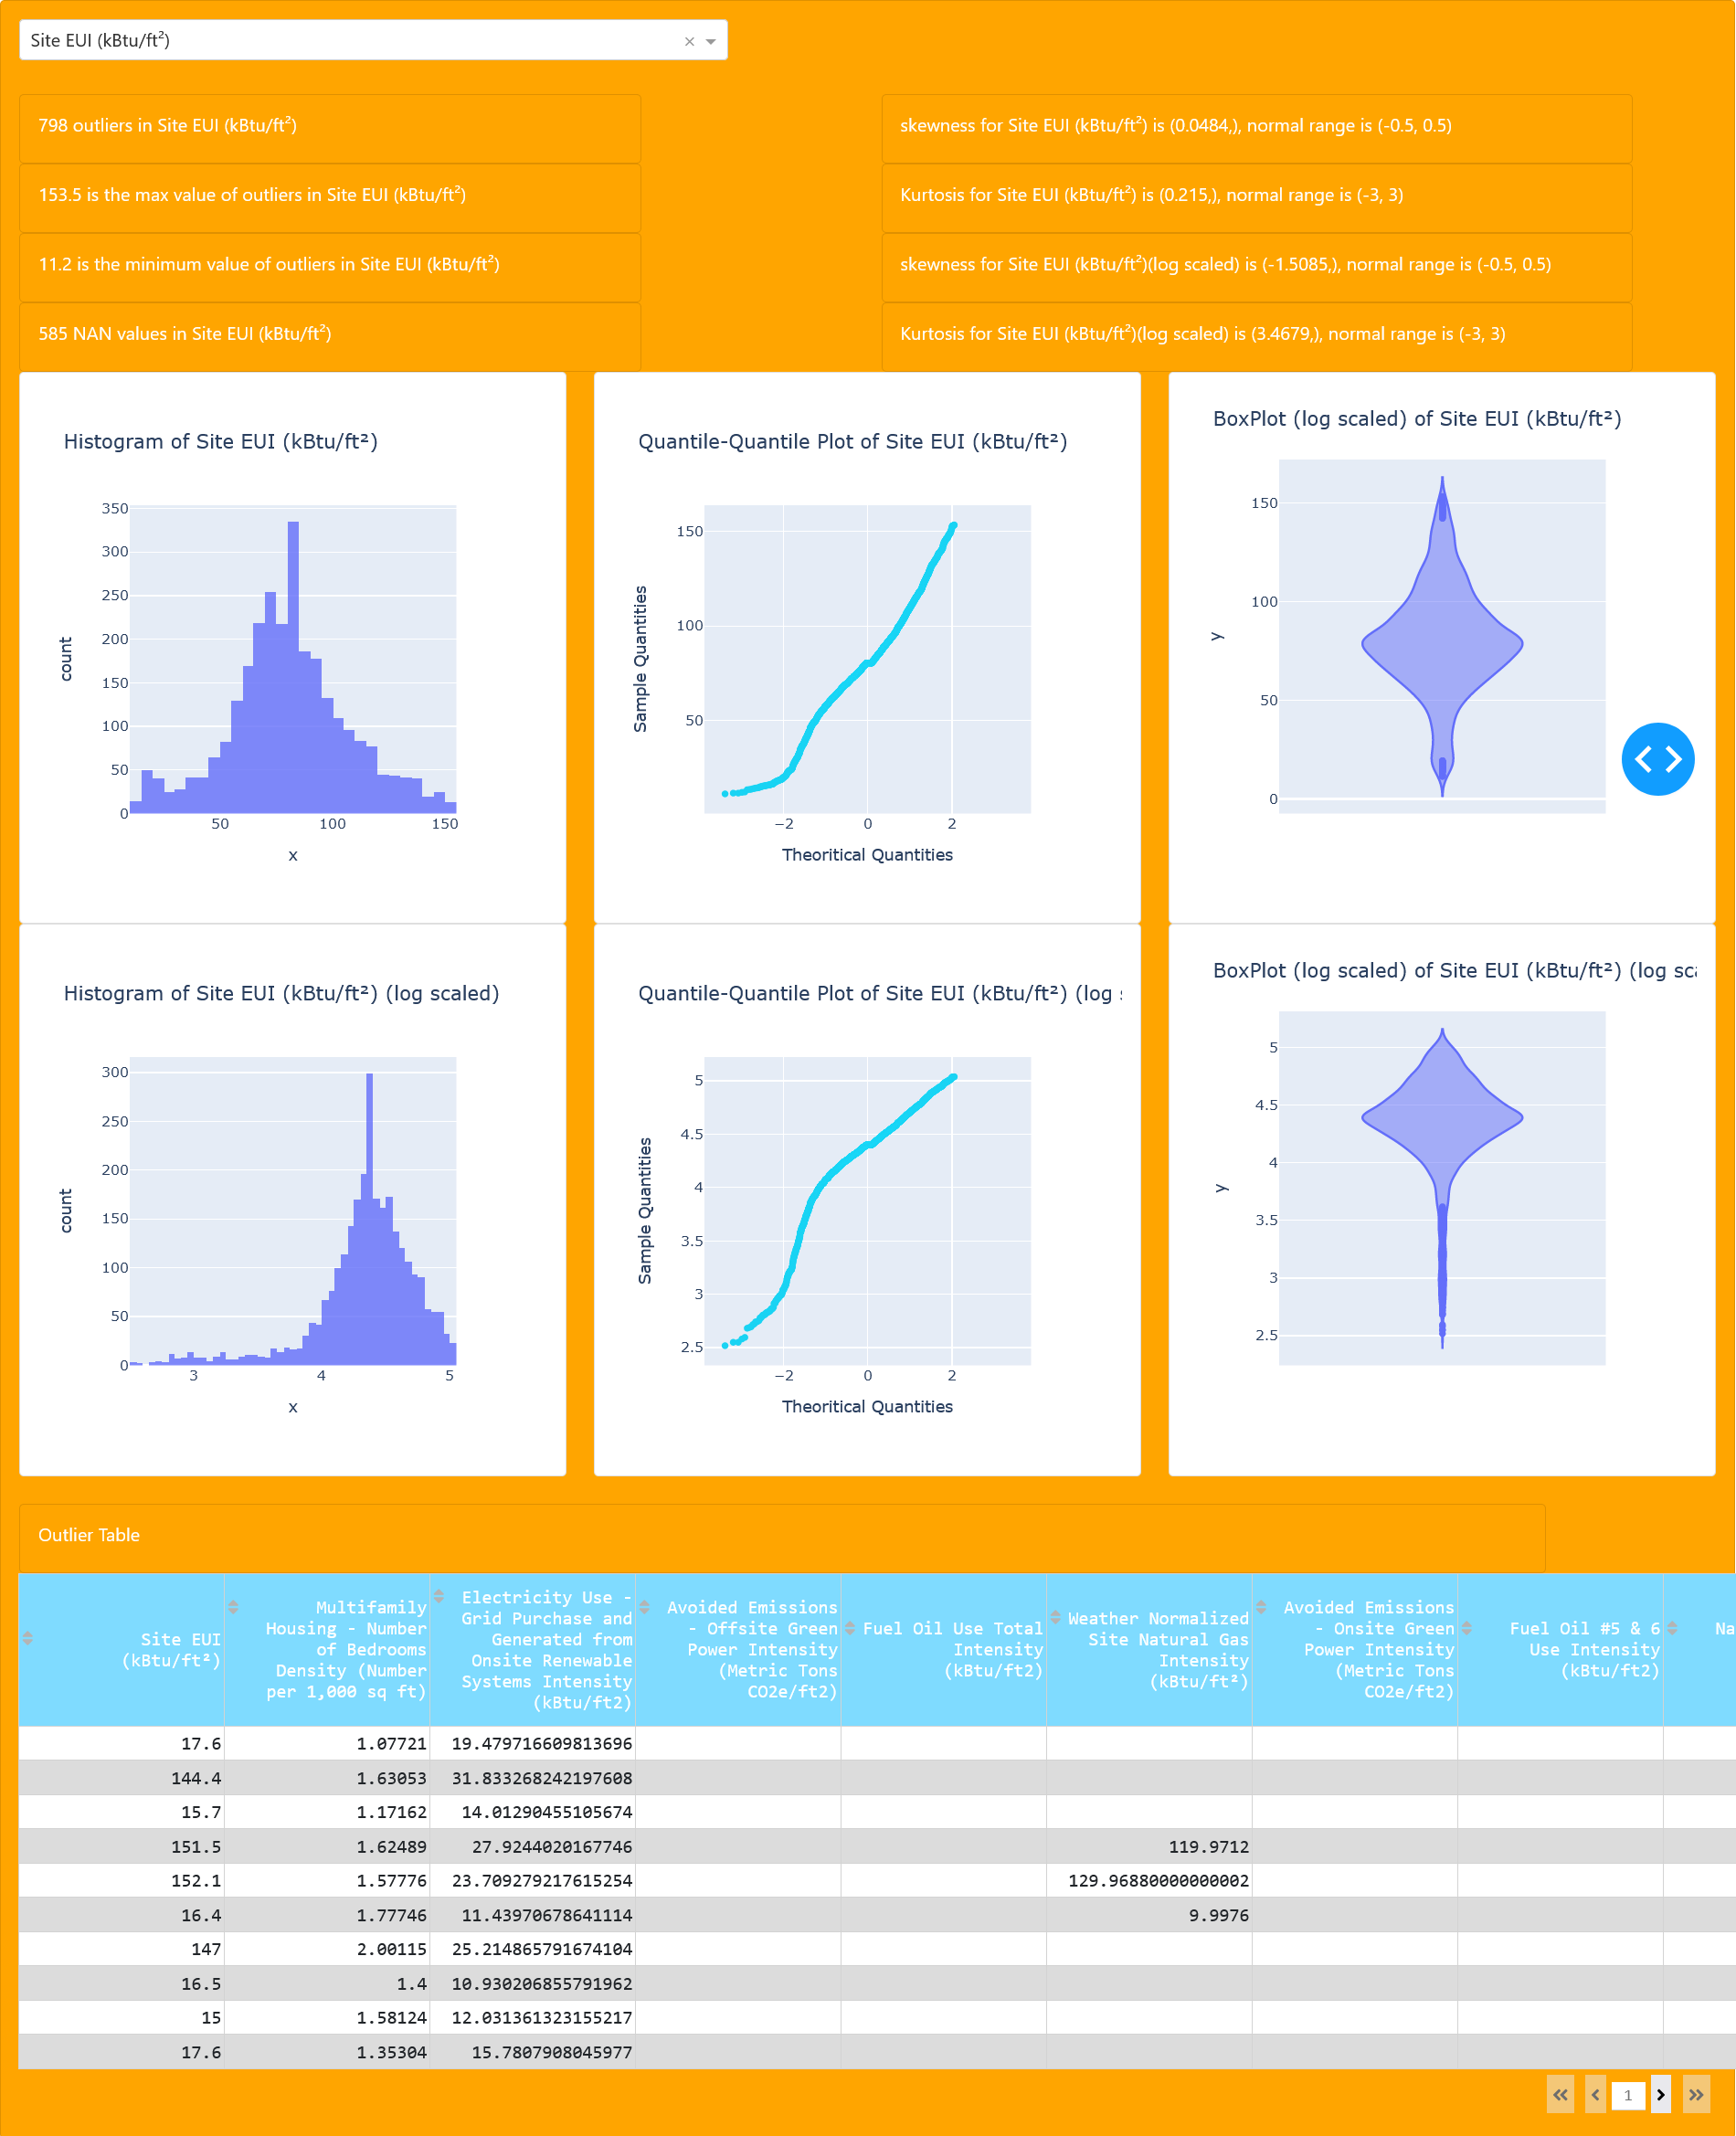

In [71]:
from IPython.display import display, Image
display(Image(filename='images/dash_outliers.png'))

In [9]:
df_energy.shape

(28582, 103)

# Normalization Techniques

https://developers.google.com/machine-learning/data-prep/transform/normalization